In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset testing

In [51]:
import torch.utils.data as data
from torchvision import transforms

In [ ]:
class OccMapDataset(data.Dataset):
    def __init__(self, filename='./description_ang0.csv', transform=None, input_dir='./inp_data/', target_dir='./gt_data/', mode='train'):
        # Your code 
        df = pd.read_csv(filename)
        df = df[df['free_perc'] <= 80]
        
        df['FloorID'] = df['FloorName'].apply(lambda x: int(x[-3:]))
        if mode == 'train':
            df = df[df['FloorID'] <= 220]
        else:
            df = df[df['FloorID'] > 220]
        
        self.filepaths = my_df['Filename'].values
        
        self.transform = transform
        self.input_dir = input_dir
        self.target_dir = target_dir

    def __len__(self):
        # Your code 
        return len(self.filepaths)
    
    def __getitem__(self, index):
        # Your code
        filename = self.filepaths[index]
        inp_img = np.load(f'{self.input_dir}/{my_filenames[0]}.npy')
        tgt_img = np.load(f'{self.output_dir}/{my_filenames[0]}.npy')
        
        data_dict = {'input image': inp_img, 'target image': tgt_img}
        
        if self.transform is not None:
            data_dict['input image'] = self.transform(data_dict['input image'])
            data_dict['target image'] = self.transform(data_dict['target image'])
        
        return data_dict

In [53]:
my_df = pd.read_csv('description_ang0.csv')
my_df.head()

,Unnamed: 0,Filename,FloorName,pos_x,pos_y,pos_z,ang_x,ang_y,ang_z,free_perc
0,0,FP201_0,FloorPlan201,-4.0,0.902657,1.5,0,0,0,71.540833
1,1,FP201_1,FloorPlan201,-4.0,0.902657,1.5,0,45,0,72.044373
2,2,FP201_2,FloorPlan201,-4.0,0.902657,1.5,0,90,0,68.254089
3,3,FP201_3,FloorPlan201,-4.0,0.902657,1.5,0,135,0,76.741028
4,4,FP201_4,FloorPlan201,-4.0,0.902657,1.5,0,180,0,84.309387


In [62]:
# my_df.shape
# pd.unique(my_df[ my_df['FloorName'].values in [f'FloorPlan{k}' for k in range(201,220+1)]])
# my_df['FloorID'] = my_df['FloorName'].apply(lambda x: int(x[-3:]))
my_df.shape, my_df[my_df['FloorID'] <= 220].shape

((15096, 11), (10864, 11))

<AxesSubplot:>

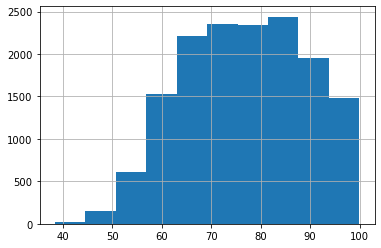

In [50]:
my_df['free_perc'].hist()

In [51]:
my_df = my_df[my_df['free_perc'] <= 80]
my_filenames = my_df['Filename'].values
print(len(my_filenames))

8641


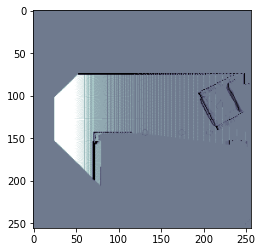

In [52]:
plt.imshow(np.load(f'inp_data/{my_filenames[0]}.npy'), cmap='bone_r')

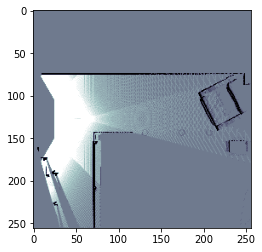

In [53]:
plt.imshow(np.load(f'gt_data/{my_filenames[0]}.npy'), cmap='bone_r')

In [1]:
import torch
from dataloader import OccMapDataset
from torchvision import transforms

In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.ConvertImageDtype(torch.float)
            ])
# load the data
full_set = OccMapDataset(filename='./description_ang0.csv', transform=transform)

In [3]:
full_loader = torch.utils.data.DataLoader(full_set, batch_size=12, shuffle=True, num_workers=2)

In [4]:
for data in full_loader:
    break

In [5]:
data['input image'].shape, data['target image'].shape

(torch.Size([12, 1, 256, 256]), torch.Size([12, 1, 256, 256]))

In [6]:
full_loader.batch_size

12

## Solver

In [54]:
from torch.utils.tensorboard import SummaryWriter

In [55]:
import torch.nn as nn

In [ ]:
nn.MSELoss()

# Test utility testing

In [1]:
from train import *

In [4]:
# Defining transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
# load the data
trainval_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='train')
test_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='test')

trainval_size = len(trainval_set)

train_size = int((100 - 10)/100. * trainval_size)
valid_size = trainval_size - train_size
test_size = len(test_set)

print(f'Data sizes:\nTrain: {train_size}\nValid: {valid_size}\nTest: {test_size}')

train_set, valid_set = torch.utils.data.random_split(trainval_set, [train_size, valid_size])

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=2*16, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2*16, shuffle=False, num_workers=2)
# model
net = UNet(n_channels=1, n_classes=1, bilinear=True)

# train the model
model_path = f"./saved_models/{'sgd'}_LR_{0.01}_epoch_{50}.pth"

solver = Solver(net, optimizer='sgd', lr=0.01, max_epoch=50, 
                verbose=True, save_best=True, early_stop=5, 
                outfile=model_path, save_full=True)
print(f'Loading pre-trained model from {model_path}')
# solver.net.load_state_dict(torch.load(model_path))
solver.net = torch.load(model_path)

test_loss = solver.test(loader=test_loader)
print(f'Test loss: {test_loss}')


Data sizes:
Train: 5641
Valid: 627
Test: 2373
Loading pre-trained model from ./saved_models/sgd_LR_0.01_epoch_50.pth
Test loss: 0.0012519644961381951


In [5]:
for data in test_loader:
    images = data['input image']
    labels = data['target image']

    # placing data on device
    images = images.to(solver.device)
    labels = labels.to(solver.device)

    # We don't need gradients here
    with torch.no_grad():
        # forward propagation 
        preds = solver.net(images)
    break

In [35]:
preds.shape

torch.Size([32, 1, 256, 256])

In [34]:
from torchvision.utils import make_grid, save_image

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

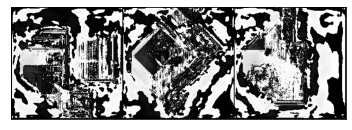

In [12]:
show(make_grid(preds[:3].cpu()))

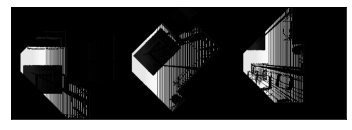

In [14]:
show(make_grid(images[:3].cpu()))

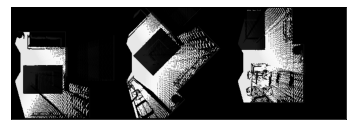

In [13]:
show(make_grid(labels[:3].cpu()))

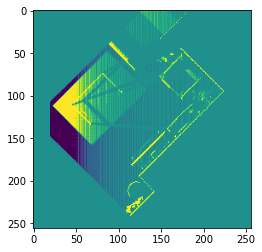

In [11]:
plt.imshow(images.cpu().data[1,0])

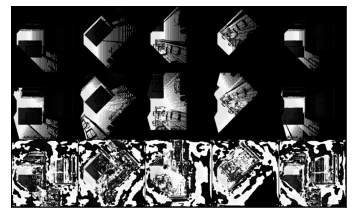

In [33]:
show(make_grid(torch.cat([images[:5], labels[:5], preds[:5]], axis=0).cpu(), nrow=5))

In [35]:
save_image(make_grid(torch.cat([images[:5], labels[:5], preds[:5]], axis=0).cpu(), nrow=5), 'example.png' )